## Toy demo
This notebook shows a simple demo to play with _Mint_. A CNN model with one convolutional layer and two linear layers is trained for around 8,000 samples on MNIST dataset. The modules available up to now:
- **Basic**: Conv2d, Linear, Sequential
- **Pooling**: MaxPool2d
- **Activation**: ReLU
- **Transform**: Flat
- **Loss**: CrossEntropy
- **Optimizer**: SGD

### Imports

In [1]:
import time
import numpy as np
import mint.modules as mo
import mint.optim as optim
from mint.data.utils import *
from mint.data.mnist import load_mnist_datasets
import matplotlib.pyplot as plt

### Load data

In [2]:
train_set, val_set, test_set = load_mnist_datasets()
## reshape data
train_x, val_x = np.reshape(train_set[0],(-1,1,28,28)), np.reshape(val_set[0],(-1,1,28,28)),
test_x = np.reshape(test_set[0],(-1,1,28,28))
## map labels to categories
train_y, val_y, test_y = train_set[1], val_set[1], test_set[1]

### Hyper-parameters

In [3]:
batch_size = 64
epochs = 1
lr = 1e-2
moment = 0.9
weight_decay = 1e-4

### Model design

In [4]:
model = mo.Sequential(
    mo.Conv2d(in_channels=1, out_channels=5, kernel_size=3),
    mo.ReLU(in_place=True),
    mo.MaxPool2d(kernel_size=4, stride=4),
#     mo.Conv2d(in_channels=5, out_channels=5, kernel_size=3),
#     mo.ReLU(in_place=True),
#     mo.MaxPool2d(kernel_size=2, stride=2),
    mo.Flat(),
    mo.Linear(5*7*7, 64),
    mo.ReLU(in_place=True),
    mo.Linear(64, 10),
)

### Objevtice function & optimizer

In [5]:
objective = mo.CrossEntropy()
optimizer = optim.SGD(model.modules, lr=lr, moment=moment, weight_decay=weight_decay)

### Training

In [6]:
loss = list()
for epoch in range(epochs):
    random_idxs = get_random_idxs(batch_size, len(train_y))
    current = time.time()
    model.train()
    for batch in range(len(random_idxs)):
        data, label = next_batch((train_x, train_y), batch, random_idxs)
        output = model.forward(data)
        optimizer.zero_grad()
        loss.append(objective.forward(output, label))
        model.backward(objective.backward())
        optimizer.step()
        if (batch+1) % 10 == 0:
            _correct = correct(output, label)
            print("[epoch %d][%d, %d] loss=%.2f, accuracy=%.2f, elapse time=%.2fs." 
                  % (epoch+1, batch+1, len(random_idxs), loss[-1], _correct * 1. / label.shape[0], time.time() - current))
            current = time.time()
        if (batch+1) % 50 == 0:
            optimizer.defaults['lr'] *= 0.7
    
        if batch == 256:
            ## eval
            model.eval()
            _correct = 0.
            idxs = get_deter_idxs(batch_size, len(test_y))
            current = time.time()
            for batch in range(len(idxs)):
                data, label = next_batch((test_x, test_y), batch, idxs)
                output = model.forward(data)
                _correct += correct(output.data, label)
                _accuracy = _correct / len(test_y)
            print("[epoch %d]Test accuracy=%.2f, elapse time=%.2fs." % (epoch+1, _accuracy, time.time() - current))
            break # too slow....

[epoch 1][10, 782] loss=2.19, accuracy=0.27, elapse time=37.46s.
[epoch 1][20, 782] loss=2.20, accuracy=0.16, elapse time=38.06s.
[epoch 1][30, 782] loss=1.89, accuracy=0.53, elapse time=37.84s.
[epoch 1][40, 782] loss=1.63, accuracy=0.56, elapse time=37.81s.
[epoch 1][50, 782] loss=1.15, accuracy=0.66, elapse time=37.66s.
[epoch 1][60, 782] loss=0.82, accuracy=0.77, elapse time=37.71s.
[epoch 1][70, 782] loss=0.80, accuracy=0.80, elapse time=37.86s.
[epoch 1][80, 782] loss=0.48, accuracy=0.84, elapse time=37.69s.
[epoch 1][90, 782] loss=0.57, accuracy=0.80, elapse time=37.87s.
[epoch 1][100, 782] loss=0.57, accuracy=0.81, elapse time=37.79s.
[epoch 1][110, 782] loss=0.66, accuracy=0.78, elapse time=38.34s.
[epoch 1][120, 782] loss=0.50, accuracy=0.86, elapse time=37.72s.
[epoch 1][130, 782] loss=0.62, accuracy=0.81, elapse time=37.79s.
[epoch 1][140, 782] loss=0.63, accuracy=0.83, elapse time=38.11s.
[epoch 1][150, 782] loss=0.73, accuracy=0.75, elapse time=37.66s.
[epoch 1][160, 782]

### Loss curve

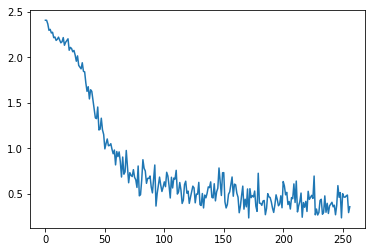

In [7]:
batches = np.arange(0, 257)
plt.plot(batches, loss)
plt.show()

### Random test

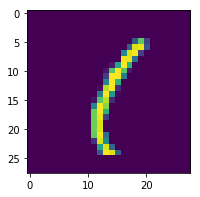

ground truth:[1], prediction:1


In [8]:
idx = np.random.choice(test_x.shape[0], 1)
x, y = test_x[idx], test_y[idx]
model.eval()
y_predict = model.forward(x)
plt.figure(figsize=(3,3))
plt.imshow(np.reshape(x,(28,28)))
plt.show()
print("ground truth:{}, prediction:{}".format(y, np.argmax(y_predict)))